<a href="https://colab.research.google.com/github/jusohn2/Facial-Emotion-Recognition/blob/main/final_jupyternotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install utils
!pip install livelossplot
!pip install keras-visualizer
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 3.2 MB/s 


# **Import the dataset of FER2013:**

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/msambare/fer2013")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: justinsohn
Your Kaggle Key: ··········


100%|██████████| 60.3M/60.3M [00:00<00:00, 173MB/s]


# **Import Libraries:**

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import pandas as pd
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread

%matplotlib inline

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications import MobileNetV2
import tensorflow_addons as tfa


import datetime
from keras.utils.vis_utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


# **Check the images of each emotion:**

In [4]:
emotion_prop=[]

for expression in os.listdir("./fer2013/train"):
    emotion_prop.append(len(os.listdir("./fer2013/train/" + expression)))
    print(str(len(os.listdir("./fer2013/train/" + expression))) + " " + expression + " images")

print("emotion_prop = ",emotion_prop)

3171 surprise images
4965 neutral images
436 disgust images
7215 happy images
4097 fear images
3995 angry images
4830 sad images
emotion_prop =  [3171, 4965, 436, 7215, 4097, 3995, 4830]


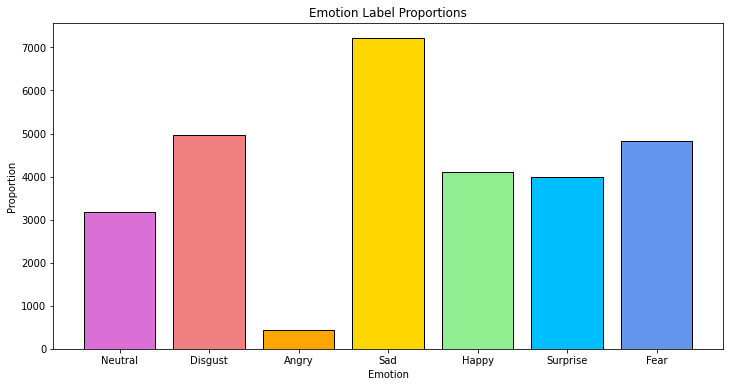

In [5]:
emotions = ['Neutral','Disgust','Angry','Sad','Happy','Surprise','Fear']
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']


plt.figure(figsize=[12,6])
plt.bar(x=emotions, height=emotion_prop, color=palette, edgecolor='black')
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()

# **Check sample of each emotion:**

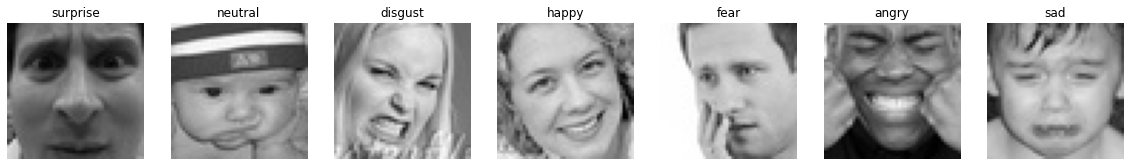

In [6]:
train_dir = './fer2013/train/'
test_dir = './fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
#train_count = count_exp(train_dir, 'train')
#test_count = count_exp(test_dir, 'test')
#print(train_count)
#print(test_count)
plt.figure(figsize=(20,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# **Build CNN Architecture:**

In [7]:
img_size = 224
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_directory("./fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_validation.flow_from_directory("./fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# Baseline model
model = Sequential()
model.add(layers.Conv2D(32, 7, input_shape=(224,224,1), padding='same',
                         activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='sigmoid'))

In [9]:
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
#save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint("model_weights5.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

#Stop training when a monitored metric has stopped improving.
early_stopp = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',min_delta=0,verbose=1, 
                                               mode='min', restore_best_weights=True)
#Callback
callbacks1 = [PlotLossesKerasTF(), checkpoint, reduce_lr,early_stopp]

# Train the baseline model:

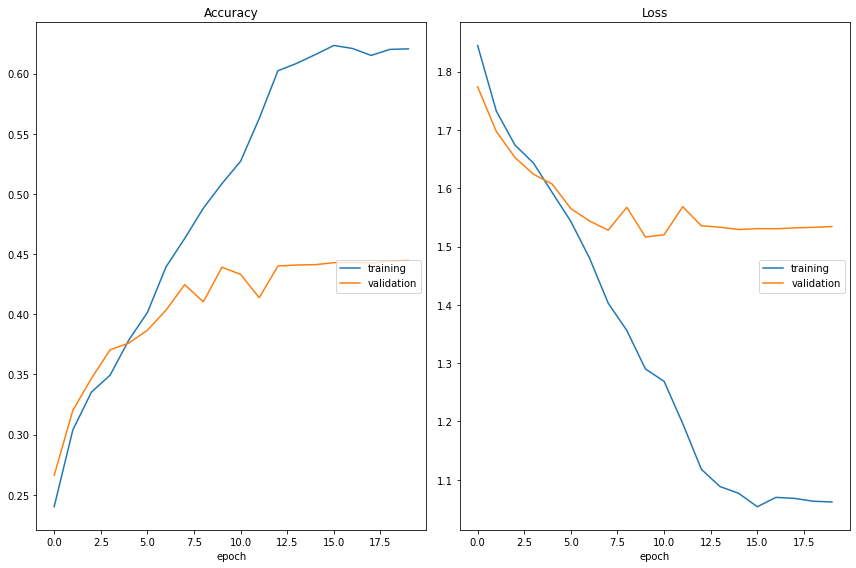

Accuracy
	training         	 (min:    0.240, max:    0.623, cur:    0.621)
	validation       	 (min:    0.266, max:    0.445, cur:    0.445)
Loss
	training         	 (min:    1.054, max:    1.845, cur:    1.062)
	validation       	 (min:    1.516, max:    1.774, cur:    1.534)

Epoch 20: saving model to model_weights5.h5
Restoring model weights from the end of the best epoch: 10.
200/200 [==============================] - 9s 47ms/step - loss: 1.0620 - acc: 0.6206 - val_loss: 1.5344 - val_acc: 0.4447 - lr: 1.0000e-05
Epoch 20: early stopping


In [10]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])
model.summary()

# Fitting the model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=200,
                    epochs=50,
                    callbacks=callbacks1)

We could see that the training accuracy is 63.5% ehile the validation accuracy is 45.5% and the loss is 1.028 for training and 1.517 for validation. 

We could try some data augmentation: 

# Add some data Augmentation:

In [11]:
img_size = 224
batch_size = 32

datagen_train = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
train_generator = datagen_train.flow_from_directory("./fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
validation_generator = datagen_validation.flow_from_directory("./fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
# Baseline model with data augmentation
model = Sequential()
model.add(layers.Conv2D(32, 7, input_shape=(224,224,1), padding='same',
                         activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='sigmoid'))

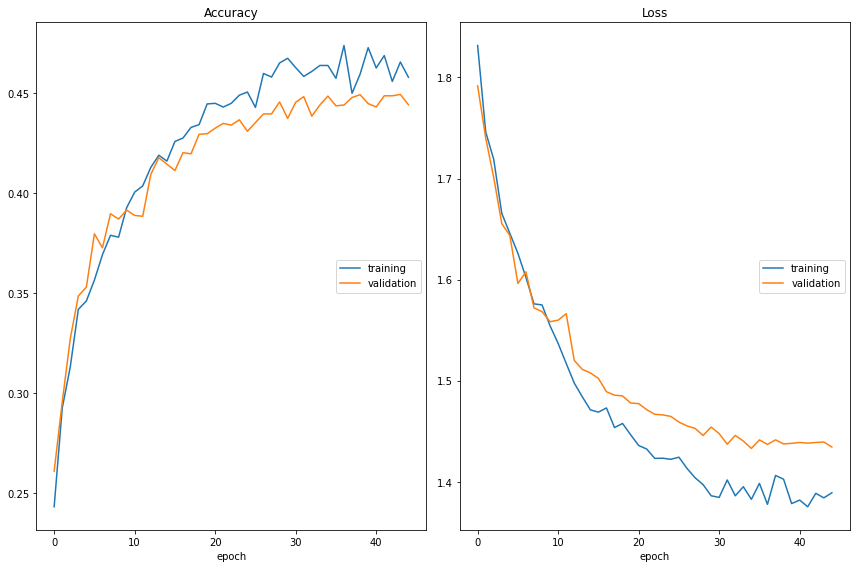

Accuracy
	training         	 (min:    0.243, max:    0.474, cur:    0.458)
	validation       	 (min:    0.261, max:    0.449, cur:    0.444)
Loss
	training         	 (min:    1.375, max:    1.832, cur:    1.389)
	validation       	 (min:    1.433, max:    1.792, cur:    1.434)

Epoch 45: saving model to model_weights5.h5
Restoring model weights from the end of the best epoch: 35.
200/200 [==============================] - 53s 267ms/step - loss: 1.3891 - acc: 0.4579 - val_loss: 1.4344 - val_acc: 0.4441 - lr: 1.0000e-05
Epoch 45: early stopping


In [13]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])
model.summary()

checkpoint = ModelCheckpoint("model_weights5.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

callbacks1 = [PlotLossesKerasTF(), checkpoint, reduce_lr,early_stopp]

# Fitting the model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=200,
                    epochs=50,
                    callbacks=callbacks1)

Here we got accuracy 49.4% for training and 46.8% for validation while the loss is 1.312 for training and 1.387 for test.

In [14]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [15]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 28s 125ms/step - loss: 1.4406 - acc: 0.4415
final train accuracy = 46.29 , validation accuracy = 44.15


Confusion Matrix
[[ 410    1  344 1295  822  661  462]
 [  44    0   40  141   84   73   54]
 [ 399    4  345 1314  854  725  456]
 [ 638    3  624 2309 1577 1239  825]
 [ 493    1  438 1640 1022  832  539]
 [ 446    4  429 1600 1000  793  558]
 [ 298    1  253 1020  658  558  383]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.10      0.12      3995
     disgust       0.00      0.00      0.00       436
        fear       0.14      0.08      0.11      4097
       happy       0.25      0.32      0.28      7215
     neutral       0.17      0.21      0.19      4965
         sad       0.16      0.16      0.16      4830
    surprise       0.12      0.12      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



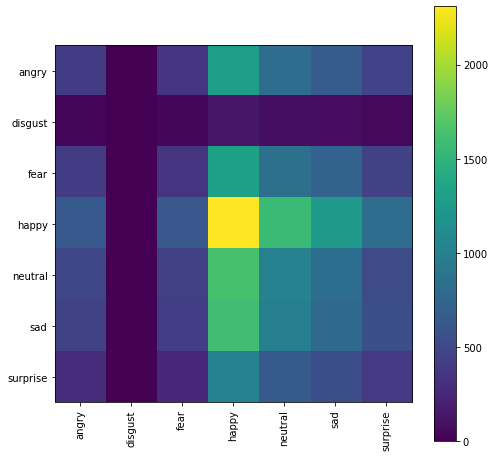

In [16]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Increase the number of layers in the CNN architecture:

In [17]:
img_size= 224
batch_size=32

datagen_train1 = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
train_generator1 = datagen_train1.flow_from_directory("./fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation1 = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
validation_generator1 = datagen_validation1.flow_from_directory("./fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
model1 =Sequential()   

model1.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(img_size,img_size,1)))
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2, 2))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(7, activation='softmax'))


In [19]:
model1.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['acc'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
checkpoint = ModelCheckpoint(filepath="model_weights5.h5",
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=10, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)
callbacks1=[PlotLossesKerasTF(),checkpoint,reduce_lr,earlystop]

In [39]:
steps_per_epoch = train_generator1.n // train_generator1.batch_size
validation_steps = validation_generator1.n // validation_generator1.batch_size

history1 = model1.fit(train_generator1,
                    validation_data=validation_generator1,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    callbacks=callbacks1)

We could see that the accuracy increased for training to be 94.1% and 56.5% for validation while the loss decreased for training to be 0.356 while for validation 1.745.

In [22]:
model_json1 = model1.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json1)


In [23]:
train_loss, train_accu = model1.evaluate(train_generator1)
test_loss, test_accu = model1.evaluate(validation_generator1)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 32s 143ms/step - loss: 4.5107 - acc: 0.1382
final train accuracy = 13.76 , validation accuracy = 13.82


Confusion Matrix
[[ 413    6    8   60  631   38 2839]
 [  40    0    0    6   74    3  313]
 [ 399    4    6   54  658   38 2938]
 [ 766    8   18  113 1152   58 5100]
 [ 509    8    6   75  812   47 3508]
 [ 455   15    4   63  748   55 3490]
 [ 326    8    5   34  489   37 2272]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.10      0.12      3995
     disgust       0.00      0.00      0.00       436
        fear       0.13      0.00      0.00      4097
       happy       0.28      0.02      0.03      7215
     neutral       0.18      0.16      0.17      4965
         sad       0.20      0.01      0.02      4830
    surprise       0.11      0.72      0.19      3171

    accuracy                           0.13     28709
   macro avg       0.15      0.14      0.08     28709
weighted avg       0.18      0.13      0.08     28709



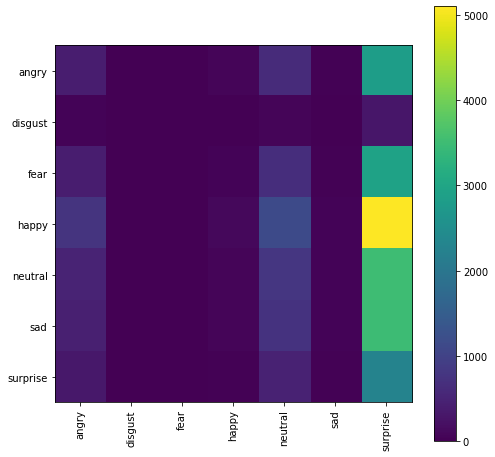

In [24]:
y_pred = model1.predict(train_generator1)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator1.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator1.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator1.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Trying pre-trained models (Transfer Learning):

**VGG19 model:**

In [25]:
img_size=224
batch_size=32

datagen_train2 = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
train_generator2 = datagen_train2.flow_from_directory("./fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation2 = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
validation_generator2 = datagen_validation2.flow_from_directory("./fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [26]:
vgg19_model = vgg19.VGG19(include_top=True,
                               weights="imagenet",
                               input_shape=(img_size,img_size,3),
                               classifier_activation="softmax",
                               classes=1000)

574726144/574710816 [==============================] - 3s 0us/step


In [27]:
model2= Sequential()

model2.add(Conv2D(3,(3,3), padding='same', input_shape=(img_size, img_size,3)))
model2.add(vgg19_model)
model2.add(Flatten())
model2.add(Dense(7, activation='softmax'))

In [28]:
model2.compile(optimizer=Adam(lr=0.00001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['acc'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 vgg19 (Functional)          (None, 1000)              143667240 
                                                                 
 flatten_3 (Flatten)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 7)                 7007      
                                                                 
Total params: 143,674,331
Trainable params: 143,674,331
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
checkpoint = ModelCheckpoint(filepath="model2_weights5.h5",
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=10, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)
callbacks1=[PlotLossesKerasTF(),checkpoint,reduce_lr,earlystop]

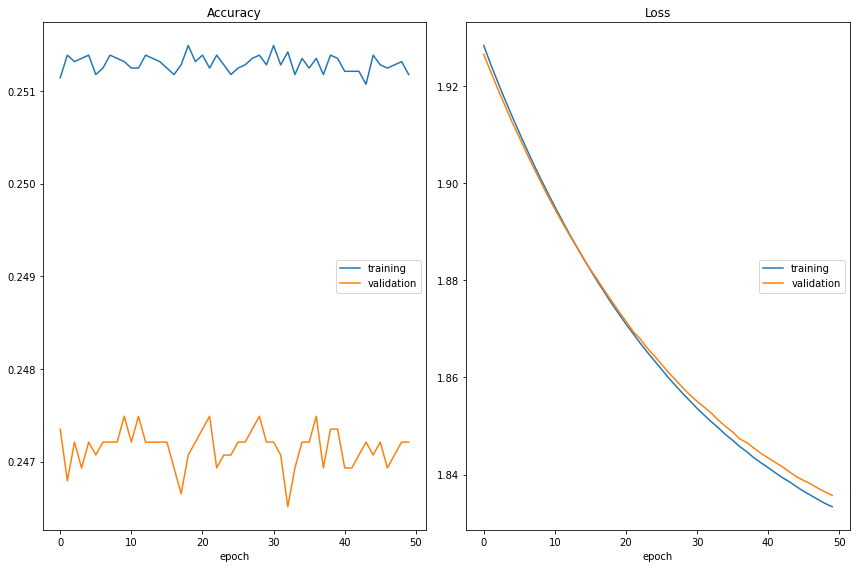

Accuracy
	training         	 (min:    0.251, max:    0.251, cur:    0.251)
	validation       	 (min:    0.247, max:    0.247, cur:    0.247)
Loss
	training         	 (min:    1.833, max:    1.928, cur:    1.833)
	validation       	 (min:    1.836, max:    1.926, cur:    1.836)

Epoch 50: val_loss improved from 1.83646 to 1.83572, saving model to model2_weights5.h5
897/897 [==============================] - 501s 558ms/step - loss: 1.8334 - acc: 0.2512 - val_loss: 1.8357 - val_acc: 0.2472 - lr: 1.0000e-05


In [30]:
steps_per_epoch = train_generator2.n // train_generator2.batch_size
validation_steps = validation_generator2.n // validation_generator2.batch_size

history2 = model2.fit(train_generator2,
                    validation_data=validation_generator2,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    callbacks=callbacks1,
                   validation_steps=validation_steps)

In [32]:
model_json2 = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json2)

As we could see that the accuracy is not increasing than 25.1%. so we would check other transfer models.

# DenseNet 121:

In [33]:
img_size=224
batch_size=32

datagen_train3 = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
train_generator3 = datagen_train3.flow_from_directory("./fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation3 = ImageDataGenerator(rotation_range=15,brightness_range=[0.2,1.0],rescale=1./255, shear_range=0.1)
validation_generator3 = datagen_validation3.flow_from_directory("./fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [34]:
DenseNet121_model = densenet.DenseNet121(include_top=True,
                               weights="imagenet",
                               input_shape=(img_size,img_size,3),
                               classes=1000)


### # Initialising the CNN
model3 = Sequential()
model3.add(DenseNet121_model)


# Fully connected layer 1st layer
model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

# Fully connected layer 2nd layer
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(7, activation='softmax'))

33202176/33188688 [==============================] - 0s 0us/step


In [35]:
model3.compile(optimizer=Adam(lr=0.00001, decay=1e-6), loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.20, gamma=2.0,reduction=tf.keras.losses.Reduction.AUTO),  
              metrics=['acc', 'Precision'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 dense_9 (Dense)             (None, 128)               128128    
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
checkpoint = ModelCheckpoint(filepath="model3_weights5.h5",
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

callbacks1=[PlotLossesKerasTF(),checkpoint,reduce_lr,earlystop]
#callbacks1=[PlotLossesKerasTF(),checkpoint,reduce_lr]

In [40]:
steps_per_epoch = train_generator3.n // train_generator3.batch_size
validation_steps = validation_generator3.n // validation_generator3.batch_size

history3 = model3.fit(train_generator3,
                    validation_data=validation_generator3,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    callbacks=callbacks1,
                   validation_steps=validation_steps)

We could see that the accuracies are not improving with more epochs.

# MobileNet model with decrease dropout number:

In [41]:
batch_size=32
img_size=224
datagen_train5 = ImageDataGenerator(rotation_range=10,brightness_range=[0.2,1.0])
train_generator5 = datagen_train5.flow_from_directory("./fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation5 = ImageDataGenerator(rotation_range=10,brightness_range=[0.2,1.0])
validation_generator5 = datagen_validation5.flow_from_directory("./fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [42]:
MobileNet_model = mobilenet.MobileNet(include_top=True,
                               weights="imagenet",
                               input_shape=(img_size,img_size,3),
                               classifier_activation="softmax",
                               classes=1000)

17235968/17225924 [==============================] - 0s 0us/step


In [43]:
# Initialising the CNN
model5 = Sequential()
model5.add(MobileNet_model)

# Fully connected layer 1st layer
model5.add(Dense(256))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.25))

# Fully connected layer 2nd layer
model5.add(Dense(512))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.25))

model5.add(Dense(7, activation='softmax'))


In [44]:
model5.compile(optimizer=Adam(lr=0.0001), loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.20, gamma=2.0,reduction=tf.keras.losses.Reduction.AUTO), metrics=['acc'])
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 256)               256256    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 512)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
epochs5 = 50
steps_per_epoch5 = train_generator5.n//train_generator5.batch_size
validation_steps5 = validation_generator5.n//validation_generator5.batch_size

#Reduce learning rate when a metric has stopped improving.
reduce_lr5 = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=0.00001, mode='auto')
#save the Keras model or model weights at some frequency.
checkpoint5 = ModelCheckpoint("model_weights5.h5", monitor='val_prc',
                             save_weights_only=True, mode='max', verbose=1)
#Stop training when a monitored metric has stopped improving.
early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#Callback
callbacks5 = [PlotLossesKerasTF(), checkpoint5, reduce_lr5,early_stopp]

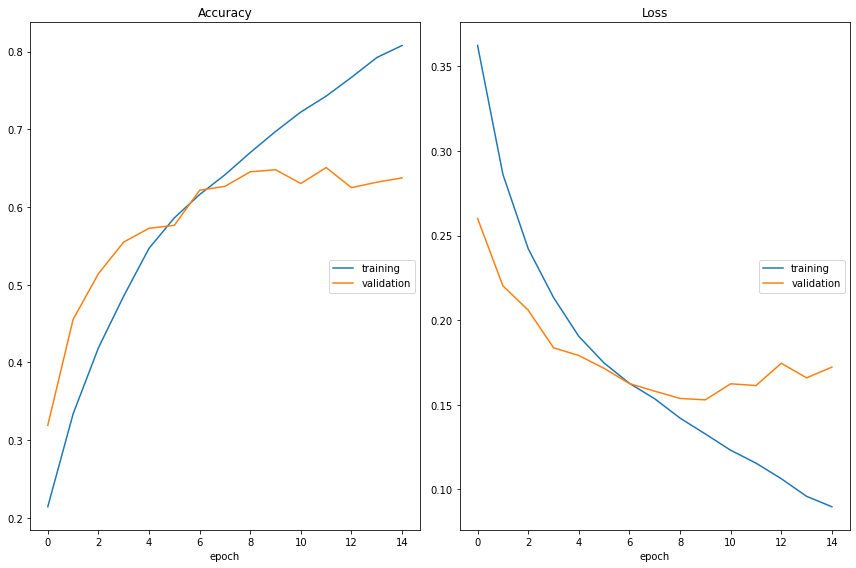

Accuracy
	training         	 (min:    0.214, max:    0.808, cur:    0.808)
	validation       	 (min:    0.319, max:    0.651, cur:    0.638)
Loss
	training         	 (min:    0.090, max:    0.362, cur:    0.090)
	validation       	 (min:    0.153, max:    0.260, cur:    0.172)

Epoch 15: saving model to model_weights5.h5
897/897 [==============================] - 439s 490ms/step - loss: 0.0897 - acc: 0.8079 - val_loss: 0.1723 - val_acc: 0.6376 - lr: 1.0000e-04


In [46]:
history5 = model5.fit(x=train_generator5,
                      steps_per_epoch=steps_per_epoch5,
                      epochs=epochs5,
                      validation_data = validation_generator5,
                      validation_steps = validation_steps5,
                      callbacks=callbacks5)

We could see that the accuracy increased to 83.8% for training and 62% for validation and the loss decreased to 0.077 for training and 0.203 for validation set.

In [47]:
model_json5 = model5.to_json()
with open("model5.json", "w") as json_file:
    json_file.write(model_json5)

In [48]:
train_loss, train_accu = model5.evaluate(train_generator5)
test_loss, test_accu = model5.evaluate(validation_generator5)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 80s 356ms/step - loss: 0.1532 - acc: 0.6441
final train accuracy = 76.25 , validation accuracy = 64.41


Confusion Matrix
[[ 454   67  614  946  817  639  458]
 [  50    5   63  104   81   65   68]
 [ 491   62  683  926  833  607  495]
 [ 902  109 1134 1717 1458 1071  824]
 [ 588   83  782 1185  915  819  593]
 [ 610   62  775 1198  995  683  507]
 [ 396   61  484  746  662  483  339]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.11      0.12      3995
     disgust       0.01      0.01      0.01       436
        fear       0.15      0.17      0.16      4097
       happy       0.25      0.24      0.24      7215
     neutral       0.16      0.18      0.17      4965
         sad       0.16      0.14      0.15      4830
    surprise       0.10      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



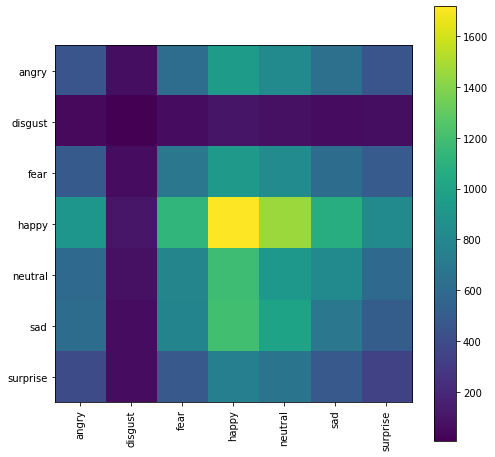

In [49]:
# Plot a confusion matrix for the MobileNet model
y_pred = model5.predict(train_generator5)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator5.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator5.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator5.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# DenseNet 121 with decrease in the dropout number:

In [50]:
batch_size=16
img_size=224

datagen_train6 = ImageDataGenerator(rotation_range=10,brightness_range=[0.2,1.0])
train_generator6 = datagen_train6.flow_from_directory("./fer2013/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation6 = ImageDataGenerator(rotation_range=10,brightness_range=[0.2,1.0])
validation_generator6 = datagen_validation6.flow_from_directory("./fer2013/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [51]:
DenseNet121_model = densenet.DenseNet121(include_top=True,
                               weights="imagenet",
                               input_shape=(img_size,img_size,3),
                               classes=1000)

# Initialising the CNN
model6 = Sequential()
model6.add(DenseNet121_model)

# Fully connected layer 1st layer
model6.add(Dense(256))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.3))

# Fully connected layer 2nd layer
model6.add(Dense(512))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.3))

model6.add(Dense(7, activation='softmax'))

model6.compile(optimizer=Adam(lr=0.00001), loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.20, gamma=2.0,reduction=tf.keras.losses.Reduction.AUTO), metrics=['acc'])
model6.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 dense_15 (Dense)            (None, 256)               256256    
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               131584    
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [52]:
epochs5 = 50
steps_per_epoch5 = train_generator6.n//train_generator6.batch_size
validation_steps5 = validation_generator6.n//validation_generator6.batch_size

#Reduce learning rate when a metric has stopped improving.
reduce_lr5 = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=0.00001, mode='auto')
#save the Keras model or model weights at some frequency.
checkpoint5 = ModelCheckpoint("model_weights6.h5", monitor='val_prc',
                             save_weights_only=True, mode='max', verbose=1)
#Stop training when a monitored metric has stopped improving.
early_stopp = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
#Callback
callbacks5 = [PlotLossesKerasTF(), checkpoint5, reduce_lr5,early_stopp]

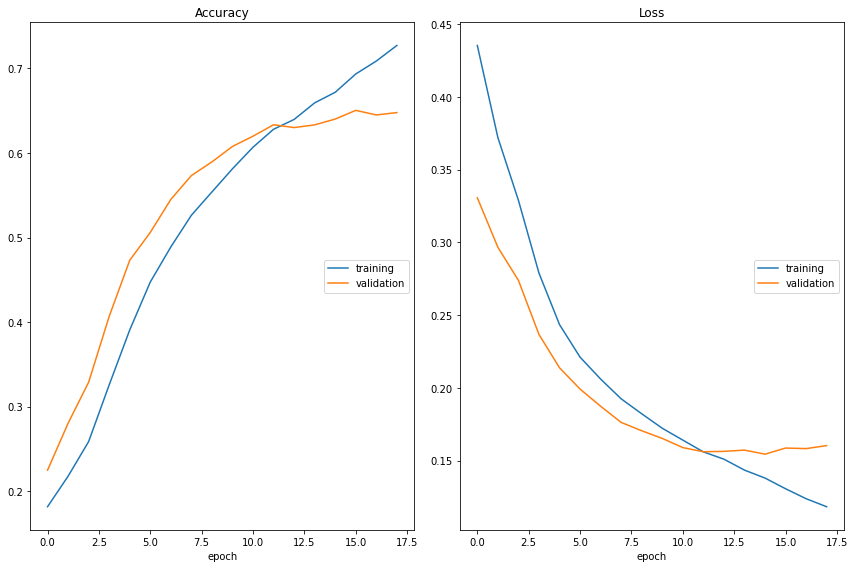

Accuracy
	training         	 (min:    0.182, max:    0.727, cur:    0.727)
	validation       	 (min:    0.225, max:    0.650, cur:    0.648)
Loss
	training         	 (min:    0.118, max:    0.435, cur:    0.118)
	validation       	 (min:    0.154, max:    0.331, cur:    0.160)

Epoch 18: saving model to model_weights6.h5
1794/1794 [==============================] - 487s 271ms/step - loss: 0.1183 - acc: 0.7271 - val_loss: 0.1603 - val_acc: 0.6477 - lr: 1.0000e-05


In [53]:
steps_per_epoch6 = train_generator6.n//train_generator6.batch_size
validation_steps6 = validation_generator6.n//validation_generator6.batch_size

history6 = model6.fit(x=train_generator6,
                      steps_per_epoch=steps_per_epoch6,
                      epochs=100,
                      validation_data = validation_generator6,
                      validation_steps = validation_steps6,
                      callbacks=callbacks5)

In [2]:
model_json6 = model6.to_json()
with open("model6.json", "w") as json_file:
    json_file.write(model_json6)

The accuracies increased to 73.6% for training set and 64.5% for validation set while the losses have decrease to the lowest numbers 0.115 for training and 0.160 for training set. which is the best model for this dataset.

In [ ]:
train_loss, train_accu = model6.evaluate(train_generator6)
test_loss, test_accu = model6.evaluate(validation_generator6)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Plot a confusion matrix for the DenseNet model with dcreased dropout

y_pred = model6.predict(train_generator6)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator6.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator6.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator6.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
Accuracy={'Baseline model':45.5,'With Data Augmentation': 46.8,'Increased number of Layers': 56.5, 'VGG19': 24.7 ,
          'DenseNet 121': 38, 'MobileNet model with decreased number of dropout': 62, 'DenseNet 121 with small drop out and large number of epochs': 64.5 }
Loss= {'Baseline model':1.517,'With Data Augmentation': 1.387 , 'Increased number of Layers': 1.745,'VGG19': 1.918,
       'DenseNet 121': 0.274, 'MobileNet model with decreased number of dropout': 0.203,'DenseNet 121 with small drop out and large number of epochs': 0.160 }
data={'Baseline model': [45.5,1.517],'With Data Augmentation': [46.8,1.387],'Increased number of Layers': [56.5,1.745], 'VGG19': [24.7,1.918] ,
          'DenseNet 121': [38,0.274], 'MobileNet model with low dropout': [62,0.203], 'DenseNet 121 with low drop out': [64.5,0.160] }
models_df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy', 'Loss'])

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

c = ['orange', 'orange', 'orange', 'orange', 'orange', 'chocolate', 'chocolate', 'chocolate', 'chocolate', 'chocolate']

plt.bar(models_df.index, (models_df['Accuracy']), color=c, label='Accuracy')

plt.ylim(0, 70)
plt.grid(False)
plt.xticks(rotation=60)
plt.ylabel('Scoring (%)')
plt.title('Model Improvements')
plt.legend(loc="upper left")
ax.get_xaxis().set_visible(True)
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))


plt.plot(models_df.index, (models_df['Loss']), color='blue', label='Loss')

plt.ylim(0, 5)
plt.grid(False)
plt.xticks(rotation=45)
plt.ylabel('Loss')
plt.title('Model Improvements')
plt.legend(loc="upper left")
ax.get_xaxis().set_visible(True)
plt.show();